# Edward

[Edward](http://edwardlib.org/) is probabilistic programming framework built using tensorflow. It is able to leverage the dynamic computation graph of tensorflow, which allows edward to be really flexible and efficient.

Tensorflow computation graph is simply **operations** as nodes and **tensors** as directed edges. Direction of the edge determines how the data (tensor) flows in the computation graph.

Edward `Random Variables` are built using tensorflow tensors. Therefore, edward RVs can be used as weights in a typical tensorflow model.

Here's is the summary of topics covered in this notebook:
* Bayesian linear regression

In [1]:
%matplotlib inline
from edward.models import Normal

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

## Sample dataset and regression
We will generate sample dataset containing 100 datapoints and 10 features.
```
X - (100, 10) sized numpy array
y - (100,) sized numpy array
```

After splitting them into train/test, we will use scikit learn to fit the linear model. We will plot the results on the validation setup.

LR MSE: 0.22372764660401107
Ridge MSE: 0.22333731036211382
Lasso MSE: 0.31403482149733514


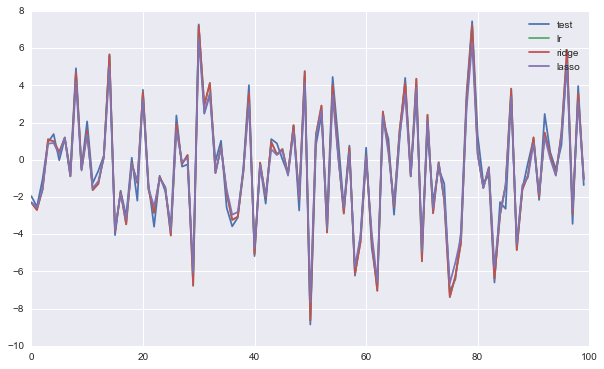

In [12]:
from sklearn.cross_validation import train_test_split
from sklearn import linear_model, metrics

# Generate Data
N = 200 # Number of datapoints - 100 train, 100 test
M = N // 2
K = 10 # Number of features
X = np.random.randn(N, K)
y = np.dot(X, np.random.randn(K)) + np.random.normal(0, 0.5, size=(N))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

# Apply scikit learn linear model
lr, ridge, lasso = linear_model.LinearRegression(), linear_model.Ridge(alpha=0.1), linear_model.Lasso(alpha=0.1)
lr.fit(X_train, y_train)
ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)
y_lr, y_ridge, y_lasso = lr.predict(X_test), ridge.predict(X_test), lasso.predict(X_test)
print('LR MSE: {}'.format(metrics.mean_squared_error(y_test, y_lr)))
print('Ridge MSE: {}'.format(metrics.mean_squared_error(y_test, y_ridge)))
print('Lasso MSE: {}'.format(metrics.mean_squared_error(y_test, y_lasso)))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='test')
plt.plot(y_lr, label='lr')
plt.plot(y_ridge, label='ridge')
plt.plot(y_lasso, label='lasso')
plt.legend()

## Bayesian Linear Regression using edward

In [16]:
X = tf.placeholder(tf.float32, [M, K])
w = Normal(mu=tf.zeros(K), sigma=tf.ones(K))
b = Normal(mu=tf.zeros(1), sigma=tf.ones(1))
y = Normal(mu=ed.dot(X, w) + b, sigma=tf.ones(M))

qw = Normal(mu=tf.Variable(tf.random_normal([K])),
            sigma=tf.nn.softplus(tf.Variable(tf.random_normal([K]))))
qb = Normal(mu=tf.Variable(tf.random_normal([1])),
            sigma=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))
inference = ed.KLqp({w: qw, b: qb}, data={X: X_train, y: y_train})
inference.run(n_samples=5, n_iter=250)

Iteration   1 [  0%]: Loss = 2006.395
Iteration  25 [ 10%]: Loss = 321.287
Iteration  50 [ 20%]: Loss = 160.664
Iteration  75 [ 30%]: Loss = 142.140
Iteration 100 [ 40%]: Loss = 134.768
Iteration 125 [ 50%]: Loss = 138.683
Iteration 150 [ 60%]: Loss = 133.764
Iteration 175 [ 70%]: Loss = 133.632
Iteration 200 [ 80%]: Loss = 131.083
Iteration 225 [ 90%]: Loss = 134.854
Iteration 250 [100%]: Loss = 133.761


In [17]:
# CRITICISM
y_post = ed.copy(y, {w: qw.mean(), b: qb.mean()})
# This is equivalent to
# y_post = Normal(mu=ed.dot(X, qw.mean()) + qb.mean(), sigma=tf.ones(N))

print("Mean squared error on test data:")
print(ed.evaluate('mean_squared_error', data={X: X_test, y_post: y_test}))

Mean squared error on test data:
0.219513
